۱. وارد کردن کتابخانه‌ها و بارگذاری داده‌ها
در این بخش تمام کتابخانه‌های مورد نیاز برای پروژه وارد شده و دیتاست بارگذاری می‌شود.

In [2]:
# وارد کردن کتابخانه‌های اصلی برای کار با داده و مصورسازی
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# وارد کردن مدل‌های یادگیری ماشین از Scikit-learn
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# وارد کردن ابزارهای ارزیابی و آماده‌سازی داده
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score

# بارگذاری دیتاست
df = pd.read_csv("oasis_longitudinal.csv")

۲. کاوش و پاک‌سازی داده‌ها (Data Cleaning & Exploration)
در این مرحله، نگاهی اولیه به داده‌ها می‌اندازیم، مقادیر گمشده را مدیریت می‌کنیم و داده‌ها را برای تحلیل آماده می‌سازیم.

In [5]:
# نمایش ۵ سطر اول دیتاست برای درک ساختار آن
print("نمایش اولیه داده‌ها:")
display(df.head())

# بررسی اطلاعات کلی دیتافریم مانند نوع داده‌ها و تعداد مقادیر غیرنال
print("\nاطلاعات کلی دیتافریم:")
df.info()

# بررسی تعداد مقادیر گمشده (NaN) در هر ستون
print("\nتعداد مقادیر گمشده در هر ستون:")
print(df.isna().sum())

# بررسی و حذف ردیف‌های تکراری (در این دیتاست تکراری وجود ندارد)
print(f"\nتعداد ردیف‌های تکراری: {df.duplicated().sum()}")

# جایگزینی مقادیر گمشده در ستون SES با میانه (Median)
# چون توزیع این ستون ممکن است چولگی داشته باشد، میانه انتخاب بهتری است
df["SES"].fillna(df["SES"].median(), inplace=True)

# جایگزینی مقادیر گمشده در ستون MMSE با میانگین (Mean)
df["MMSE"].fillna(df["MMSE"].mean(), inplace=True)

print("\nتعداد مقادیر گمشده پس از پاک‌سازی:")
print(df.isna().sum())

نمایش اولیه داده‌ها:


,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034



اطلاعات کلی دیتافریم:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  373 non-null    object 
 1   MRI ID      373 non-null    object 
 2   Group       373 non-null    object 
 3   Visit       373 non-null    int64  
 4   MR Delay    373 non-null    int64  
 5   M/F         373 non-null    object 
 6   Hand        373 non-null    object 
 7   Age         373 non-null    int64  
 8   EDUC        373 non-null    int64  
 9   SES         354 non-null    float64
 10  MMSE        371 non-null    float64
 11  CDR         373 non-null    float64
 12  eTIV        373 non-null    int64  
 13  nWBV        373 non-null    float64
 14  ASF         373 non-null    float64
dtypes: float64(5), int64(5), object(5)
memory usage: 43.8+ KB

تعداد مقادیر گمشده در هر ستون:
Subject ID     0
MRI ID         0
Group          0
Visit          0
MR Delay    

۳. مصورسازی و تحلیل داده‌ها (Data Visualization)
در این بخش، با استفاده از نمودارها، توزیع و روابط بین متغیرها را بررسی می‌کنیم.

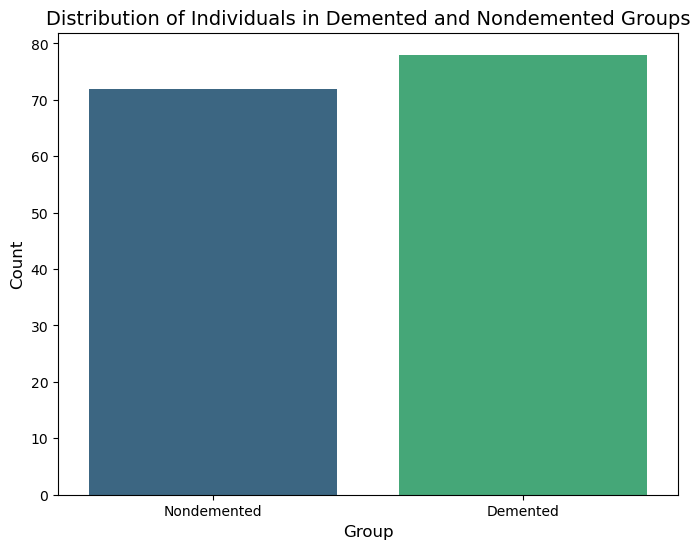

In [8]:
# برای تحلیل، فقط اولین ویزیت هر فرد را در نظر می‌گیریم تا شمارش تکراری نداشته باشیم
first_visit_df = df.loc[df['Visit'] == 1].copy()

# جایگزینی برچسب 'Converted' با 'Demented'
# افرادی که وضعیتشان به زوال عقل تغییر کرده، در نهایت در گروه دارای زوال عقل قرار می‌گیرند
first_visit_df['Group'] = first_visit_df['Group'].replace('Converted', 'Demented')
df['Group'] = df['Group'].replace('Converted', 'Demented')

# رسم نمودار توزیع فراوانی گروه‌ها
plt.figure(figsize=(8, 6))
sns.countplot(x='Group', data=first_visit_df, palette='viridis')
plt.title('Distribution of Individuals in Demented and Nondemented Groups', fontsize=14)
plt.xlabel('Group', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

تحلیل نمودار بالا:
نمودار نشان می‌دهد که تعداد افراد در دو گروه "Demented" (دارای زوال عقل) و "Nondemented" (بدون زوال عقل) تقریباً متعادل است. این موضوع برای ساخت یک مدل پیش‌بینی‌کننده خوب، نکته مثبتی است.

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


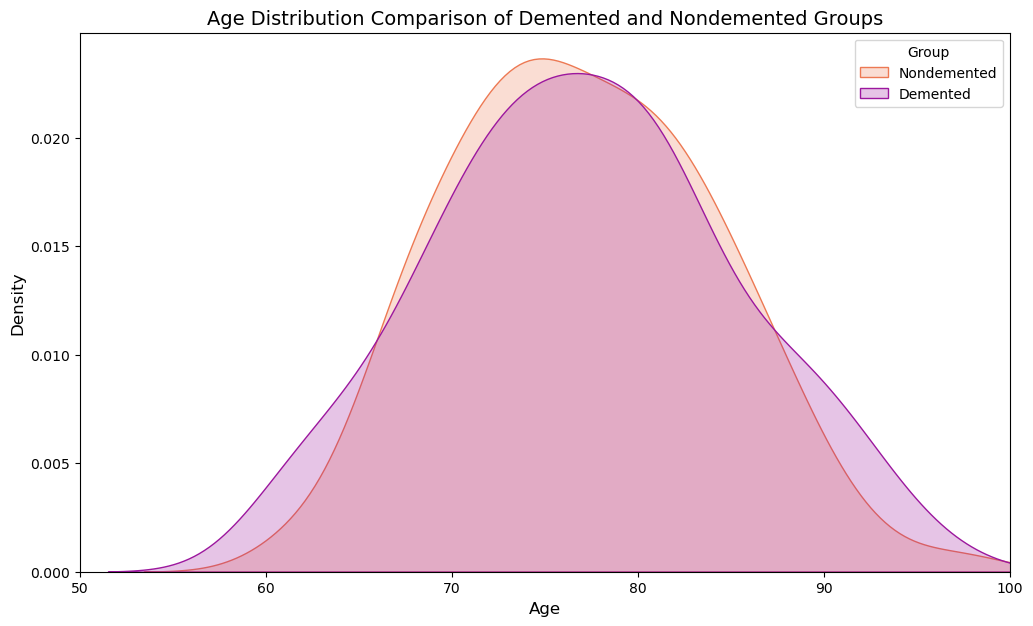

In [11]:
# مقایسه توزیع سنی دو گروه
plt.figure(figsize=(12, 7))
sns.kdeplot(data=df, x='Age', hue='Group', fill=True, palette='plasma')
plt.title('Age Distribution Comparison of Demented and Nondemented Groups', fontsize=14)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.xlim(50, 100)
plt.legend(title='Group', labels=['Nondemented', 'Demented'])
plt.show()

تحلیل نمودار بالا:
همانطور که مشاهده می‌شود، تراکم سنی افراد دارای زوال عقل (Demented) در بازه ۷۰ تا ۸۰ سال بیشتر است. همچنین، تعداد افراد بالای ۹۰ سال در گروه بدون زوال عقل (Nondemented) بیشتر به نظر می‌رسد که می‌تواند نشان‌دهنده طول عمر کمتر افراد مبتلا به آلزایمر باشد.

۴. آماده‌سازی داده‌ها برای مدل‌سازی
در این بخش، داده‌های دسته‌بندی را به فرمت عددی تبدیل کرده و مجموعه داده را به دو بخش آموزشی و آزمایشی تقسیم می‌کنیم.

In [15]:
# تبدیل متغیرهای متنی (دسته‌بندی) به عددی
# مدل‌های یادگیری ماشین فقط با داده‌های عددی کار می‌کنند
for column in ['M/F', 'Group', 'Hand']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])

print("نمایش داده‌ها پس از تبدیل به فرمت عددی:")
display(df.head())

# تعریف متغیرهای ویژگی (X) و متغیر هدف (y)
feature_cols = ["M/F", "Age", "EDUC", "SES", "MMSE", "eTIV", "nWBV", "ASF"]
X = df[feature_cols].values
y = df['Group'].values

# تقسیم داده‌ها به دو مجموعه آموزشی (70%) و آزمایشی (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

print(f"\nاندازه مجموعه آموزشی: {X_train.shape}")
print(f"اندازه مجموعه آزمایشی: {X_test.shape}")

نمایش داده‌ها پس از تبدیل به فرمت عددی:


,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,1,1,0,1,0,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,1,2,457,1,0,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,0,1,0,1,0,75,12,2.0,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,0,2,560,1,0,76,12,2.0,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,0,3,1895,1,0,80,12,2.0,22.0,0.5,1698,0.701,1.034



اندازه مجموعه آموزشی: (261, 8)
اندازه مجموعه آزمایشی: (112, 8)


۵. تعریف توابع ارزیابی مدل
برای جلوگیری از تکرار کد، توابعی برای ارزیابی عملکرد مدل‌ها تعریف می‌کنیم. این توابع معیارهای مختلفی مانند ماتریس درهم‌ریختگی، دقت و نمودار ROC را محاسبه و نمایش می‌دهند.

In [44]:
def plot_confusion_matrix(y_true, y_pred):
    """این تابع ماتریس درهم‌ریختگی را رسم می‌کند."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Nondemented', 'Demented'],
                yticklabels=['Nondemented', 'Demented'])
    plt.title('Confusion Matrix', fontsize=14)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.show()

def plot_roc_curve(model, X_test, y_test):
    """این تابع نمودار ROC را برای مدل رسم می‌کند."""
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curve', fontsize=14)
    plt.legend(loc="lower right")
    plt.show()

def evaluate_model(model, X_test, y_test):
    """این تابع عملکرد کلی یک مدل را گزارش می‌دهد."""
    y_pred = model.predict(X_test)
    
    # گزارش طبقه‌بندی
    print("گزارش طبقه‌بندی (Classification Report):")
    print(classification_report(y_test, y_pred, target_names=['Nondemented', 'Demented']))
    
    # دقت مدل
    acc = accuracy_score(y_test, y_pred)
    print(f"دقت مدل (Accuracy): {acc:.4f}\n")
    
    # رسم ماتریس درهم‌ریختگی
    plot_confusion_matrix(y_test, y_pred)
    
    # رسم نمودار ROC
    # (برای مدل‌هایی که تابع predict_proba دارند)
    if hasattr(model, "predict_proba"):
        plot_roc_curve(model, X_test, y_test)
        
    return acc

۶. ساخت، آموزش و ارزیابی مدل‌ها
در این بخش، مدل‌های مختلف یادگیری ماشین را بر روی داده‌های آموزشی، آموزش داده و سپس عملکرد آن‌ها را روی داده‌های آزمایشی ارزیابی می‌کنیم.

۶.۱. رگرسیون لجستیک (Logistic Regression)

=============== Logistic Regression Evaluation ===============
گزارش طبقه‌بندی (Classification Report):
              precision    recall  f1-score   support

 Nondemented       0.75      0.63      0.68        60
    Demented       0.64      0.75      0.69        52

    accuracy                           0.69       112
   macro avg       0.69      0.69      0.69       112
weighted avg       0.70      0.69      0.69       112

دقت مدل (Accuracy): 0.6875



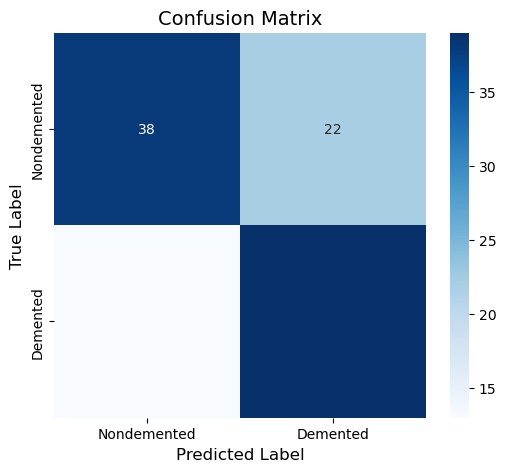

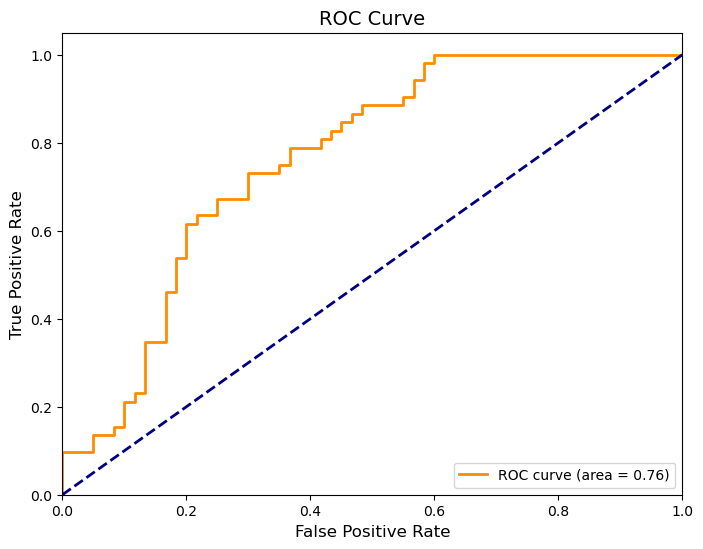

In [50]:
# ساخت و آموزش مدل رگرسیون لجستیک
log_reg = LogisticRegression(solver='liblinear', max_iter=10000, random_state=42)
log_reg.fit(X_train, y_train)

# ارزیابی مدل
print("="*15, "Logistic Regression Evaluation", "="*15)
accuracy_log_reg = evaluate_model(log_reg, X_test, y_test)

۶.۲. درخت تصمیم (Decision Tree)

=============== Decision Tree Evaluation ===============
گزارش طبقه‌بندی (Classification Report):
              precision    recall  f1-score   support

 Nondemented       0.78      0.82      0.80        60
    Demented       0.78      0.73      0.75        52

    accuracy                           0.78       112
   macro avg       0.78      0.77      0.77       112
weighted avg       0.78      0.78      0.78       112

دقت مدل (Accuracy): 0.7768



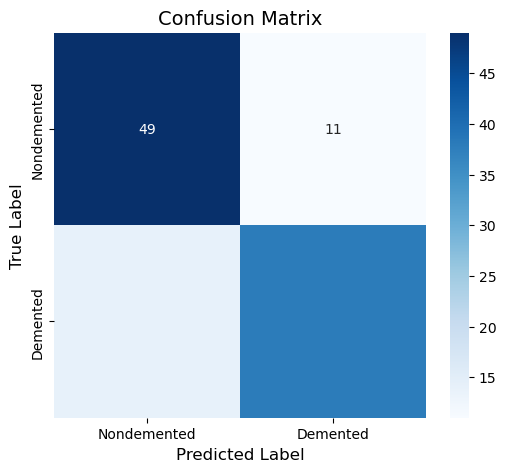

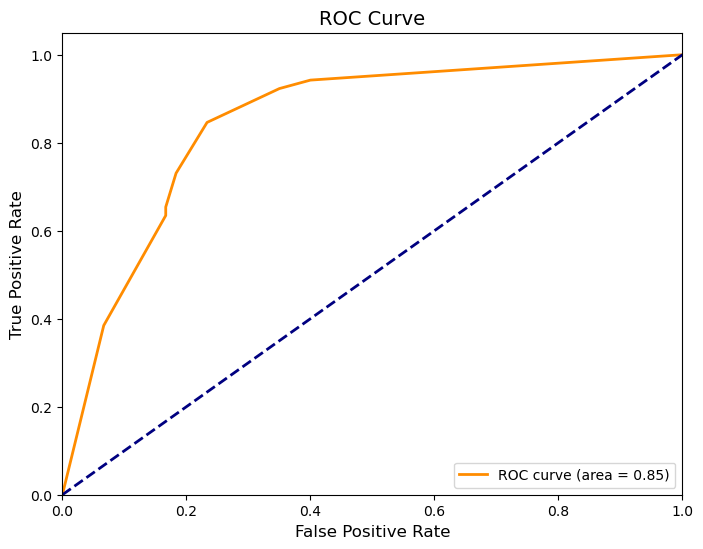

In [53]:
# ساخت و آموزش مدل درخت تصمیم
dec_tree = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)
dec_tree.fit(X_train, y_train)

# ارزیابی مدل
print("="*15, "Decision Tree Evaluation", "="*15)
accuracy_dec_tree = evaluate_model(dec_tree, X_test, y_test)

۶.۳. ماشین بردار پشتیبان (SVM)

=============== Support Vector Machine (SVM) Evaluation ===============
گزارش طبقه‌بندی (Classification Report):
              precision    recall  f1-score   support

 Nondemented       0.84      0.72      0.77        60
    Demented       0.72      0.85      0.78        52

    accuracy                           0.78       112
   macro avg       0.78      0.78      0.78       112
weighted avg       0.79      0.78      0.78       112

دقت مدل (Accuracy): 0.7768



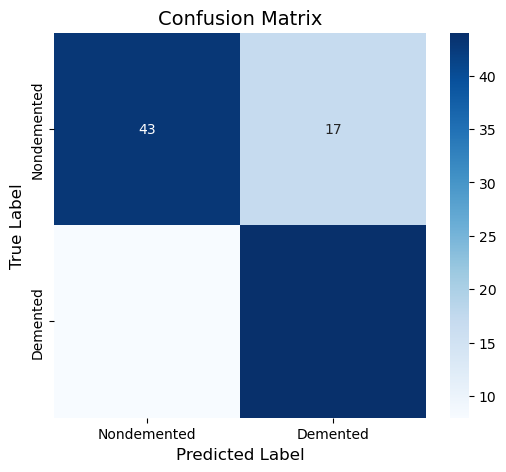

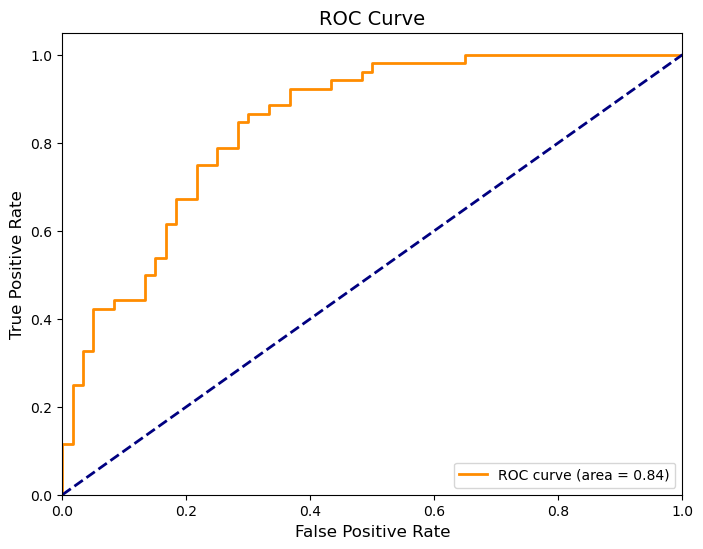

In [56]:
# ساخت و آموزش مدل SVM
# probability=True برای رسم نمودار ROC ضروری است
svm_model = SVC(kernel="linear", C=0.1, probability=True, random_state=42)
svm_model.fit(X_train, y_train)

# ارزیابی مدل
print("="*15, "Support Vector Machine (SVM) Evaluation", "="*15)
accuracy_svm = evaluate_model(svm_model, X_test, y_test)

۶.۴. k-نزدیک‌ترین همسایه (KNN)

=============== ارزیابی k-نزدیک‌ترین همسایه ===============
گزارش طبقه‌بندی (Classification Report):
              precision    recall  f1-score   support

 Nondemented       0.73      0.77      0.75        60
    Demented       0.71      0.67      0.69        52

    accuracy                           0.72       112
   macro avg       0.72      0.72      0.72       112
weighted avg       0.72      0.72      0.72       112

دقت مدل (Accuracy): 0.7232



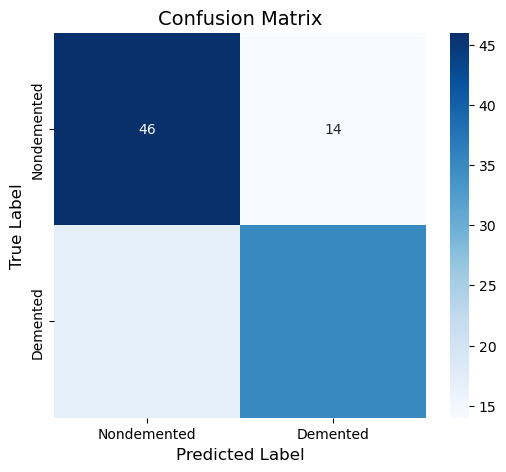

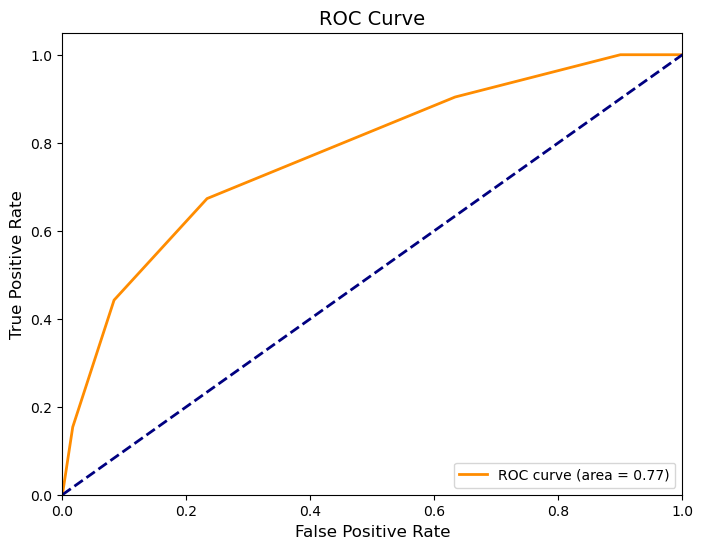

In [61]:
# ساخت و آموزش مدل KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

# ارزیابی مدل
print("="*15, "ارزیابی k-نزدیک‌ترین همسایه", "="*15)
accuracy_knn = evaluate_model(knn_model, X_test, y_test)

۷. مقایسه نهایی مدل‌ها
در نهایت، دقت مدل‌های مختلف را در کنار هم مقایسه می‌کنیم تا بهترین مدل را برای این مسئله شناسایی کنیم.

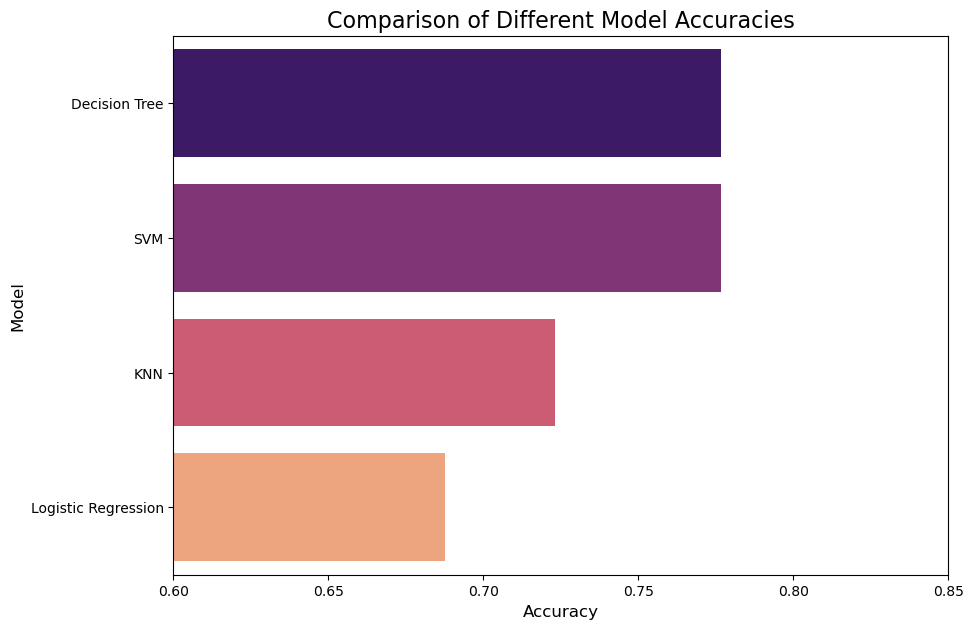


جدول مقایسه دقت مدل‌ها:


,Model,Accuracy
1,Decision Tree,0.776786
2,SVM,0.776786
3,KNN,0.723214
0,Logistic Regression,0.687500


In [64]:
# ایجاد یک دیتافریم برای مقایسه دقت مدل‌ها
model_accuracies = {
    'Logistic Regression': accuracy_log_reg,
    'Decision Tree': accuracy_dec_tree,
    'SVM': accuracy_svm,
    'KNN': accuracy_knn
}

accuracy_df = pd.DataFrame(list(model_accuracies.items()), columns=['Model', 'Accuracy'])
accuracy_df = accuracy_df.sort_values(by='Accuracy', ascending=False)

# رسم نمودار مقایسه‌ای
plt.figure(figsize=(10, 7))
sns.barplot(x='Accuracy', y='Model', data=accuracy_df, palette='magma')
plt.title('Comparison of Different Model Accuracies', fontsize=16)
plt.xlabel('Accuracy', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.xlim(0.6, 0.85) # تنظیم بازه محور x برای نمایش بهتر تفاوت‌ها
plt.show()

print("\nجدول مقایسه دقت مدل‌ها:")
display(accuracy_df)

نتیجه‌گیری نهایی:
بر اساس نمودار و جدول بالا، می‌توان مشاهده کرد که مدل‌های رگرسیون لجستیک و ماشین بردار پشتیبان (SVM) بهترین عملکرد را با دقت‌های مشابه در این مسئله از خود نشان داده‌اند. مدل درخت تصمیم نیز عملکرد خوبی داشته، در حالی که مدل KNN کمترین دقت را ثبت کرده است.